In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch import nn

In [20]:
#HYPERPARAMETERS
learning_rate=0.001
epochs=10
batch_size= 300
number_of_pc=30 #number of principal components (for PCA)

In [3]:
train_data = torchvision.datasets.MNIST(root="./",train=True,transform=transforms.ToTensor(),download=True)
test_data = torchvision.datasets.MNIST(root="./",train=False,transform=transforms.ToTensor(),download=True)

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=len(test_data),shuffle=False)

In [5]:
test_sample_loader = torch.utils.data.DataLoader(dataset=test_data.data[9705:9715],shuffle=False,batch_size=10)

In [6]:
train_dataset=train_data.data.reshape(train_data.data.shape[0],train_data.data.shape[1]*train_data.data.shape[2])
test_dataset = test_data.data.reshape(test_data.data.shape[0],test_data.data.shape[1]*test_data.data.shape[2])
test_dataset_sampled= test_dataset[np.arange(9705,9715),:]

#**Question 1**

In [9]:
def PCA(input_data,top_k_ev):
  '''
  function: This function performs pca.
  Input: input_data = (torch matrix) = of shape num_datapts,784pixels
          top_k_ev = (integer) = how many principal components to be taken

  Output: top_k_eigen_vectors= shape(784,top_k_ev) top k eigen vectors in columns
          centered_ip_data= shape(num_datapts,784) = centered ip data (used for reconstruction from principal components)
          
  '''

  input_mean = torch.mean(input_data,0)
  centered_ip_data = input_data-input_mean
  cov_matrix = torch.matmul(centered_ip_data.T,centered_ip_data)
  eigen_values, eigen_vectors = torch.linalg.eigh(cov_matrix)
  eigen_values_descending,indices = torch.sort(eigen_values,descending=True)
  top_k_eigen_values,top_k_indices = eigen_values_descending[:top_k_ev],indices[:top_k_ev]
  top_k_eigen_vectors = eigen_vectors[:,top_k_indices]


  assert top_k_eigen_vectors.shape == (784,top_k_ev)
  assert centered_ip_data.shape == input_data.shape
  assert input_mean.shape == torch.Size([784])

  return top_k_eigen_vectors

In [10]:
pc=PCA(train_dataset.float(),number_of_pc)

In [11]:
def reconstruct_data(principal_components,dataset):
  '''
  function: This function reconstructs the datapoints in lower dimension (i.e. top k eigen_vector components).
  
  Input: principal_components= shape(784,top_k_ev) top k eigen vectors in columns
          centered_ip_data= shape(num_datapts,784) = centered ip data (used for reconstruction from principal components) 
  
  Output: projected_data = (torch matrix) = of shape num_datapts , top_k_ev
  
  '''
  projection_matrix = torch.matmul(principal_components,principal_components.T)
  projected_data = torch.matmul(dataset,projection_matrix) 

  assert projected_data.shape == (dataset.shape[0],principal_components.shape[0])
  
  return projected_data

In [12]:
reconstructed_test_data_sampled=reconstruct_data(pc,test_dataset_sampled.float())

In [13]:
class AE1(nn.Module):
  def __init__(self):
    super(AE1, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,30),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(30,128),
        nn.ReLU(),
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256,784),
        nn.ReLU())
    
  def forward(self,x):
    x=self.encoder(x)
    encoded_output=x
    x=self.decoder(x)
    return x,encoded_output

In [14]:
model1=AE1()
criterion1=nn.MSELoss()
optimizer1 = torch.optim.Adam(model1.parameters(),lr=learning_rate)

training_loss=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    outputs,_=model1(images)
    loss=criterion1(outputs,images)
    training_loss.append(loss.item())

    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


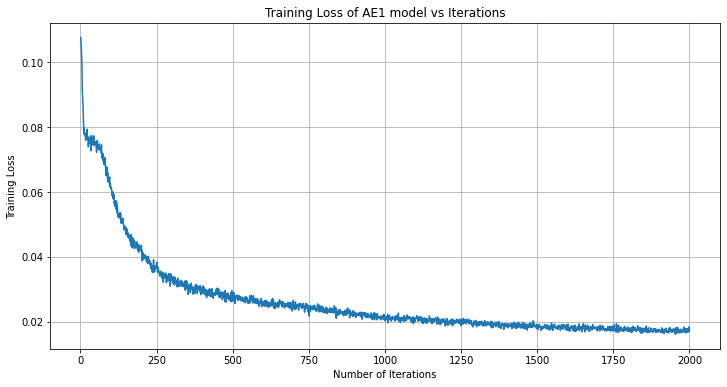

In [15]:
plt.figure(figsize=(12,6))
plt.plot(range(1,len(training_loss)+1),training_loss)
plt.title("Training Loss of AE1 model vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.grid()

_______________________________________________________________________________________
Reconstruction Error in AE: 2.7472248430821784
Reconstruction Error in PCA: 4.90691098406753


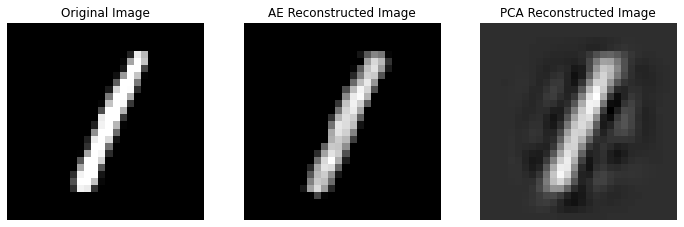

_______________________________________________________________________________________
Reconstruction Error in AE: 21.762326668644867
Reconstruction Error in PCA: 16.86237506274601


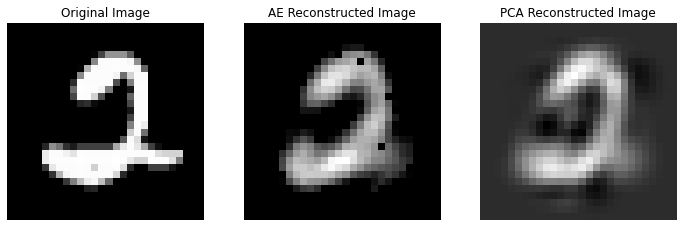

_______________________________________________________________________________________
Reconstruction Error in AE: 21.333864113817814
Reconstruction Error in PCA: 16.045755599921307


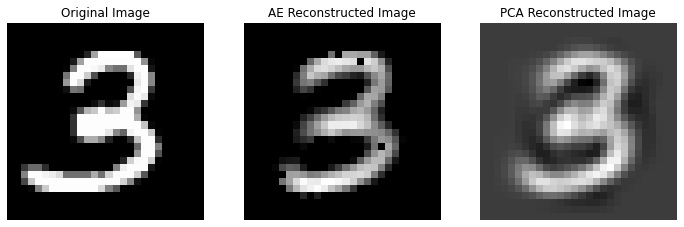

_______________________________________________________________________________________
Reconstruction Error in AE: 14.849075947558745
Reconstruction Error in PCA: 10.714795712809165


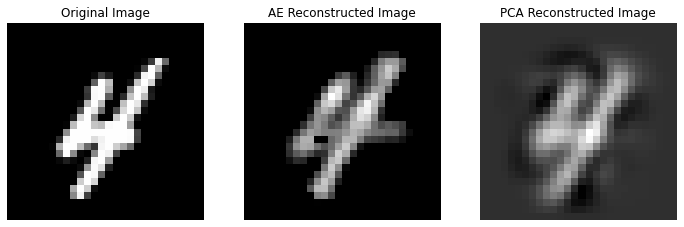

_______________________________________________________________________________________
Reconstruction Error in AE: 15.122479463273889
Reconstruction Error in PCA: 14.848193698340676


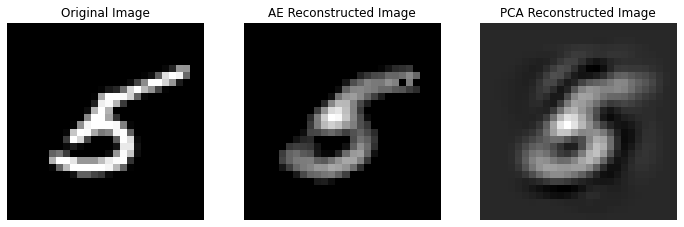

_______________________________________________________________________________________
Reconstruction Error in AE: 22.65667615807221
Reconstruction Error in PCA: 20.390818940836983


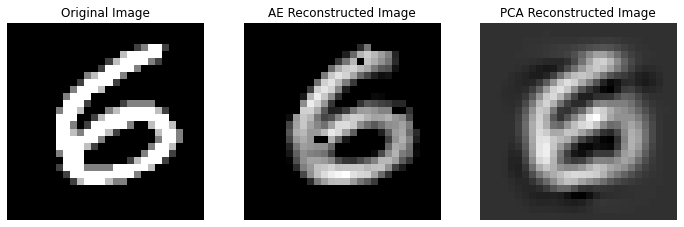

_______________________________________________________________________________________
Reconstruction Error in AE: 16.34095082586718
Reconstruction Error in PCA: 11.735863192062858


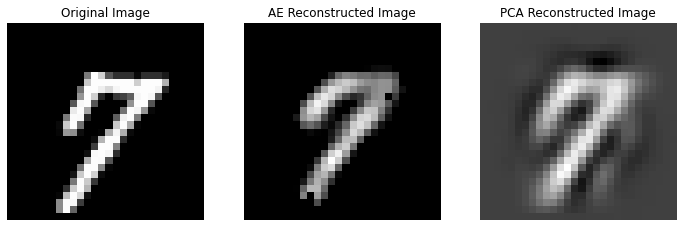

_______________________________________________________________________________________
Reconstruction Error in AE: 15.306385477625026
Reconstruction Error in PCA: 14.35657074432876


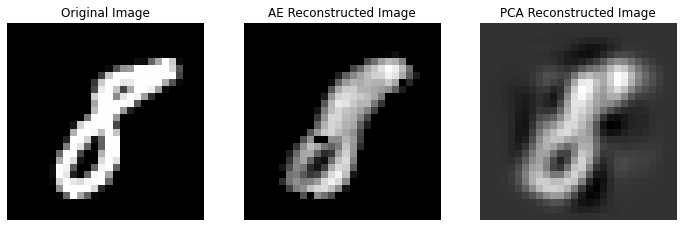

_______________________________________________________________________________________
Reconstruction Error in AE: 14.786297900784824
Reconstruction Error in PCA: 13.215489962853521


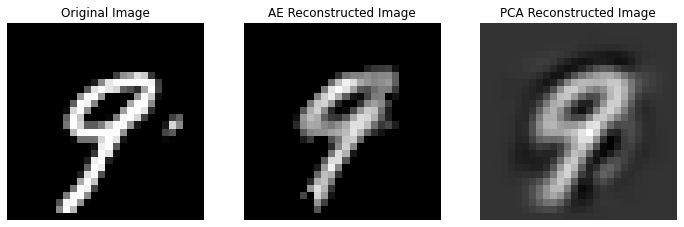

_______________________________________________________________________________________
Reconstruction Error in AE: 19.088079263514267
Reconstruction Error in PCA: 16.605796880360153


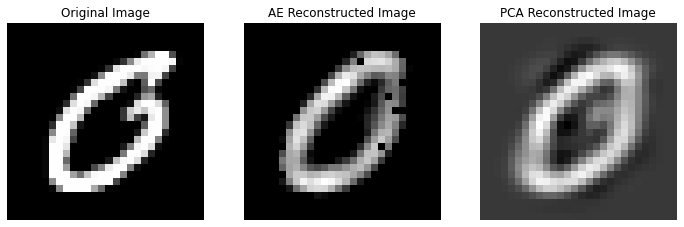

In [16]:
#MODEL EVALUATION AND RESULT PLOTTING
model1.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs,_ = model1(images.float())

plt.rcParams["figure.figsize"] = (12,6)
for i in range (10):
  fig, (ax1, ax2, ax3) = plt.subplots(1,3)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('AE Reconstructed Image')
  ax2.axis("off")

  ax3.imshow(reconstructed_test_data_sampled[i].reshape(28,28),cmap='gray')
  ax3.set_title('PCA Reconstructed Image')
  ax3.axis("off")
  print("_______________________________________________________________________________________")
  print("Reconstruction Error in AE:",np.dot(((images[i].detach().numpy()/255)-(outputs[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs[i].detach().numpy()/255)).T))
  print("Reconstruction Error in PCA:",np.dot(((images[i].detach().numpy()/255)-(reconstructed_test_data_sampled[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(reconstructed_test_data_sampled[i].detach().numpy()/255)).T))
  plt.show()

**Observations:**
- Visually, Reconstructed Autoencoder images look appealing as they have better contrast.
- Reconstruction error-wise, Reconstructed PCA images are found to have lesser error (doesnot have much difference though), however they lack the contrast. 

#**Question 2**

In [21]:
class AE2(nn.Module):
  def __init__(self,hid):
    super(AE2, self).__init__()
    self.hid=hid
    self.encoder = nn.Sequential(
        nn.Linear(784,self.hid),
        nn.ReLU()
        )
    self.decoder =nn.Sequential(
        nn.Linear(self.hid,784),
        nn.ReLU()
        )
    
  def forward(self,x):
    x=self.encoder(x)
    encoded_output=x
    x=self.decoder(x)
    return x,encoded_output

In [18]:
#HIDDEN_SIZE=64
model_hid64=AE2(64)
criterion_hid64=nn.MSELoss()
optimizer_hid64 = torch.optim.Adam(model_hid64.parameters(),lr=learning_rate)

training_loss_hid64=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    outputs,_=model_hid64(images)
    loss=criterion_hid64(outputs,images)
    training_loss_hid64.append(loss.item())

    optimizer_hid64.zero_grad()
    loss.backward()
    optimizer_hid64.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [19]:
#HIDDEN_SIZE=128
model_hid128=AE2(128)
criterion_hid128=nn.MSELoss()
optimizer_hid128 = torch.optim.Adam(model_hid128.parameters(),lr=learning_rate)

training_loss_hid128=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    outputs,_=model_hid128(images)
    loss=criterion_hid128(outputs,images)
    training_loss_hid128.append(loss.item())

    optimizer_hid128.zero_grad()
    loss.backward()
    optimizer_hid128.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [22]:
#HIDDEN_SIZE=256
model_hid256=AE2(256)
criterion_hid256=nn.MSELoss()
optimizer_hid256 = torch.optim.Adam(model_hid256.parameters(),lr=learning_rate)

training_loss_hid256=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    outputs,_=model_hid256(images)
    loss=criterion_hid256(outputs,images)
    training_loss_hid256.append(loss.item())

    optimizer_hid256.zero_grad()
    loss.backward()
    optimizer_hid256.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


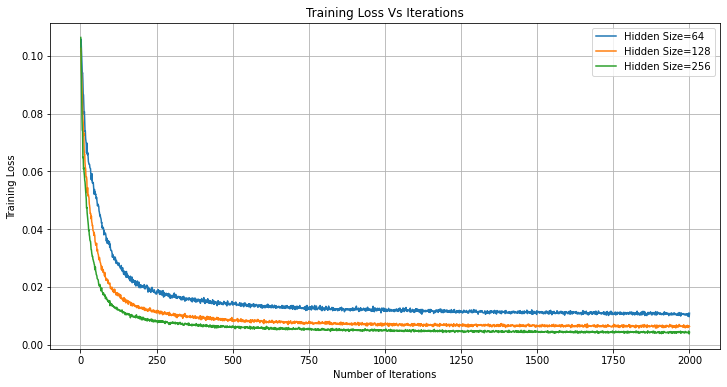

In [21]:
plt.plot(range(1,len(training_loss_hid64)+1),training_loss_hid64,label="Hidden Size=64")
plt.plot(range(1,len(training_loss_hid64)+1),training_loss_hid128,label="Hidden Size=128")
plt.plot(range(1,len(training_loss_hid64)+1),training_loss_hid256,label="Hidden Size=256")
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()


Reconstruction Error in AE_hid64: 17.168603545148102
Reconstruction Error in AE_hid128: 10.844266659450152
Reconstruction Error in AE_hid256: 9.580246903034212


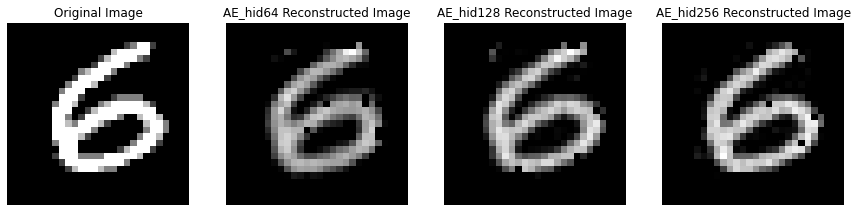

In [22]:
model_hid64.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid64,_ = model_hid64(images.float())

model_hid128.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid128,_ = model_hid128(images.float())


model_hid256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    outputs_hid256,activations_hid256 = model_hid256(images.float())


plt.rcParams["figure.figsize"] = (15,6)
i=5
if i==5:
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_hid64[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('AE_hid64 Reconstructed Image')
  ax2.axis("off")

  ax3.imshow(outputs_hid128[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('AE_hid128 Reconstructed Image')
  ax3.axis("off")

  ax4.imshow(outputs_hid256[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('AE_hid256 Reconstructed Image')
  ax4.axis("off")

  print("Reconstruction Error in AE_hid64:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid64[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hid64[i].detach().numpy()/255)).T))
  print("Reconstruction Error in AE_hid128:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid128[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hid128[i].detach().numpy()/255)).T))
  print("Reconstruction Error in AE_hid256:",np.dot(((images[i].detach().numpy()/255)-(outputs_hid256[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_hid256[i].detach().numpy()/255)).T))  

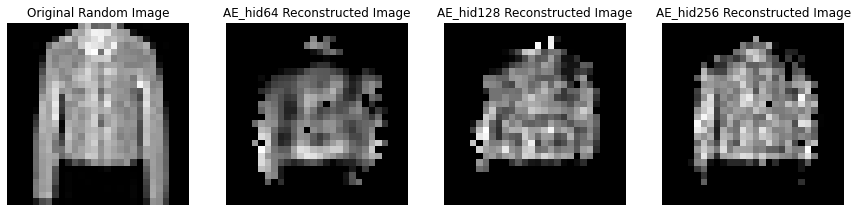

In [23]:
#FASHION MNIST OUTPUT
test_data_fashion = torchvision.datasets.FashionMNIST(root="./",train=False,transform=transforms.ToTensor(),download=True)
fashion_image_sample=test_data_fashion.data[10]

model_hid64.eval()
with torch.no_grad():
    images = fashion_image_sample.reshape(1,28*28)
    outputs_hid64,_ = model_hid64(images.float())

model_hid128.eval()
with torch.no_grad():
  images = fashion_image_sample.reshape(1,28*28)
  outputs_hid128,_ = model_hid128(images.float())

model_hid256.eval()
with torch.no_grad():
  images = fashion_image_sample.reshape(1,28*28)
  outputs_hid256,_ = model_hid256(images.float())


plt.rcParams["figure.figsize"] = (15,6)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

ax1.imshow(fashion_image_sample.detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Random Image')
ax1.axis("off")

ax2.imshow(outputs_hid64.detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('AE_hid64 Reconstructed Image')
ax2.axis("off")

ax3.imshow(outputs_hid128.detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('AE_hid128 Reconstructed Image')
ax3.axis("off")

ax4.imshow(outputs_hid256.detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title('AE_hid256 Reconstructed Image')
ax4.axis("off")
plt.show()

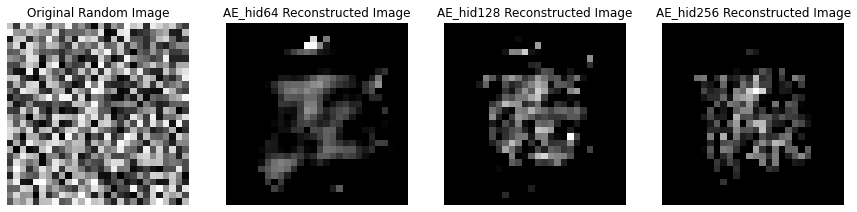

In [24]:
#OUTPUTS FOR RANDOM IMAGE
torch.manual_seed(0)
random_image=torch.randint(low=0, high=255,size=(1,28,28))

model_hid64.eval()
with torch.no_grad():
    images = random_image.reshape(1,28*28)
    outputs_hid64,_ = model_hid64(images.float())

model_hid128.eval()
with torch.no_grad():
  images = random_image.reshape(1,28*28)
  outputs_hid128,_ = model_hid128(images.float())

model_hid256.eval()
with torch.no_grad():
  images = random_image.reshape(1,28*28)
  outputs_hid256,_ = model_hid256(images.float())

plt.rcParams["figure.figsize"] = (15,6)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)

ax1.imshow(random_image.numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Random Image')
ax1.axis("off")

ax2.imshow(outputs_hid64.detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('AE_hid64 Reconstructed Image')
ax2.axis("off")

ax3.imshow(outputs_hid128.detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('AE_hid128 Reconstructed Image')
ax3.axis("off")

ax4.imshow(outputs_hid256.detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title('AE_hid256 Reconstructed Image')
ax4.axis("off")
plt.show()

**Observations:**
- For an image sample from MNIST dataset, AE with hidden size 256 seems to reconstruct the image in a better manner. This was expected as more components would able to reproduce the image in a better manner by capturing the minor details of the input image. This is also proved by the lesser reconstruction error by this model.

- For an image from Fashion MNIST dataset, the models try to reconstruct the image but the models with 64 and 128 hidden size could not reconstruct properly. On the other hand, 256 hidden size model does better job than them but also seems to struggle in the reconstruction, though if the model was trained on fashion mnist dataset, it would've performed better. 

- For a random image, the models perform as if they were trying to find out the digits, so the center pixels have some noisy output and the outer/edge pixels seem to be off (similar to the MNIST digit dataset, as our model has been trained on them.)

#**Question 3**

In [25]:
class AE3_SparseAutoencoder(nn.Module):
  def __init__(self):
    super(AE3_SparseAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,1156),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(1156,784),
        nn.ReLU())
    
  def forward(self,x):
    x=self.encoder(x)
    encoded_output=x
    l1_norm=torch.norm(x,p=1)
    x=self.decoder(x)
    return x,l1_norm,encoded_output 

In [26]:
lambda_ = 3*1e-6
model_3_a=AE3_SparseAutoencoder()
criterion_3_a=nn.MSELoss()
optimizer_3_a = torch.optim.Adam(model_3_a.parameters(),lr=learning_rate)

training_loss_3_a=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    outputs,l1_norm,_=model_3_a(images)
    loss=criterion_3_a(outputs,images)+lambda_*l1_norm
    training_loss_3_a.append(loss.item())

    optimizer_3_a.zero_grad()
    loss.backward()
    optimizer_3_a.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [27]:
lambda_ = 1.5*1e-6
model_3_b=AE3_SparseAutoencoder()
criterion_3_b=nn.MSELoss()
optimizer_3_b = torch.optim.Adam(model_3_b.parameters(),lr=learning_rate)

training_loss_3_b=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    outputs,l1_norm,_=model_3_b(images)
    loss=criterion_3_b(outputs,images)+lambda_*l1_norm
    training_loss_3_b.append(loss.item())

    optimizer_3_b.zero_grad()
    loss.backward()
    optimizer_3_b.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [28]:
lambda_ = 0.6*1e-6
model_3_c=AE3_SparseAutoencoder()
criterion_3_c=nn.MSELoss()
optimizer_3_c = torch.optim.Adam(model_3_c.parameters(),lr=learning_rate)

training_loss_3_c=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    outputs,l1_norm,_=model_3_c(images)
    loss=criterion_3_c(outputs,images)+lambda_*l1_norm
    training_loss_3_c.append(loss.item())

    optimizer_3_c.zero_grad()
    loss.backward()
    optimizer_3_c.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


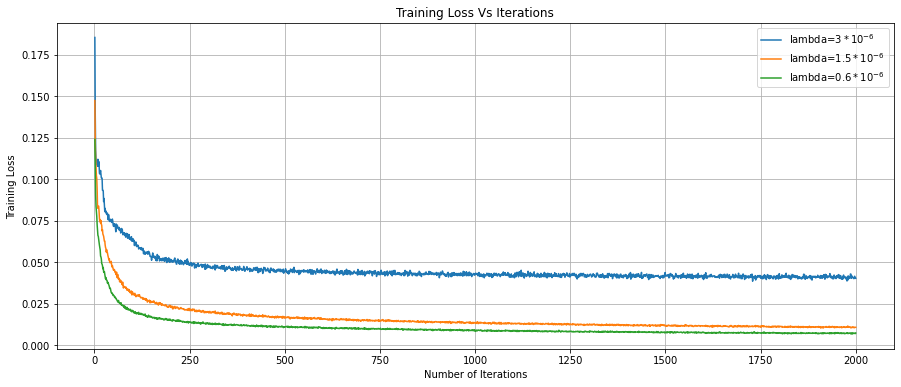

In [29]:
plt.plot(range(1,len(training_loss_3_a)+1),training_loss_3_a,label="lambda=$3*10^{-6}$")
plt.plot(range(1,len(training_loss_3_a)+1),training_loss_3_b,label="lambda=$1.5*10^{-6}$")
plt.plot(range(1,len(training_loss_3_a)+1),training_loss_3_c,label="lambda=$0.6*10^{-6}$")
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()


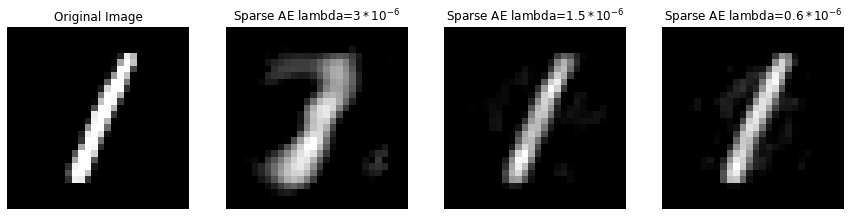

Reconstruction Error in SparseAE lambda = 3*1e-6: 14.973617678392557
Reconstruction Error in SparseAE lambda = 1.5*1e-6: 2.6136766127468603
Reconstruction Error in SparseAE lambda = 0.6*1e-6: 3.2484096543665415
______________________________________________________________________________________________


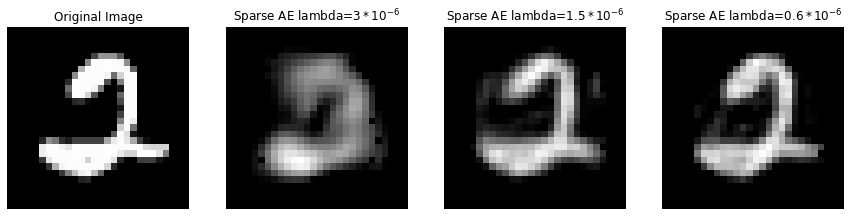

Reconstruction Error in SparseAE lambda = 3*1e-6: 31.45378367254754
Reconstruction Error in SparseAE lambda = 1.5*1e-6: 10.790227452525357
Reconstruction Error in SparseAE lambda = 0.6*1e-6: 10.529698923976387
______________________________________________________________________________________________


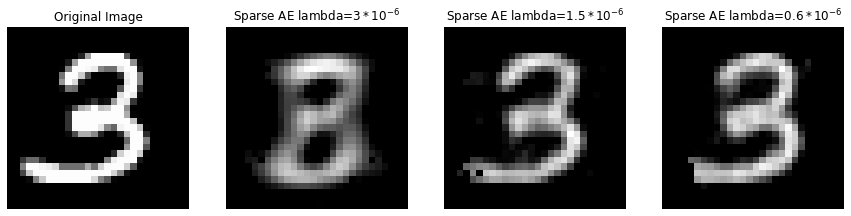

Reconstruction Error in SparseAE lambda = 3*1e-6: 35.407050044721316
Reconstruction Error in SparseAE lambda = 1.5*1e-6: 8.960318206225043
Reconstruction Error in SparseAE lambda = 0.6*1e-6: 13.305245851263557
______________________________________________________________________________________________


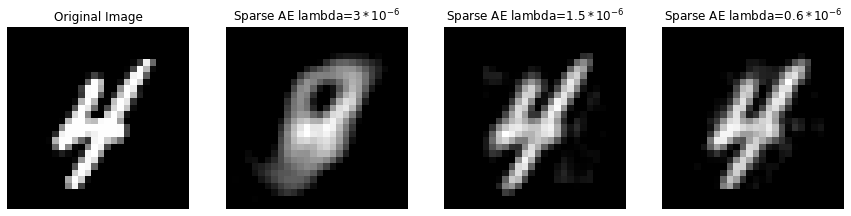

Reconstruction Error in SparseAE lambda = 3*1e-6: 28.65200092778902
Reconstruction Error in SparseAE lambda = 1.5*1e-6: 5.530929734977816
Reconstruction Error in SparseAE lambda = 0.6*1e-6: 5.769043922433602
______________________________________________________________________________________________


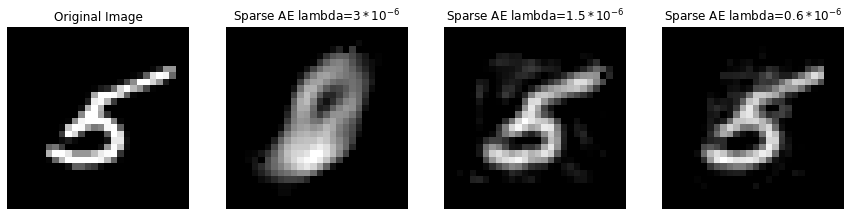

Reconstruction Error in SparseAE lambda = 3*1e-6: 35.12167571625308
Reconstruction Error in SparseAE lambda = 1.5*1e-6: 8.692977980021633
Reconstruction Error in SparseAE lambda = 0.6*1e-6: 7.520814899001559
______________________________________________________________________________________________


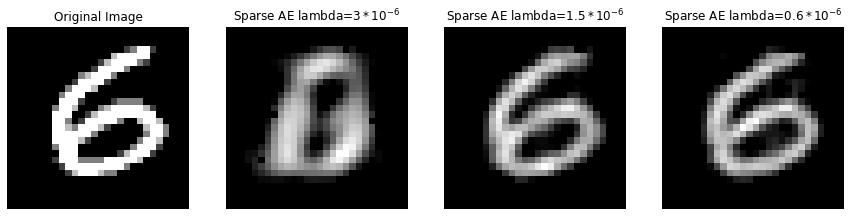

Reconstruction Error in SparseAE lambda = 3*1e-6: 60.559072609549965
Reconstruction Error in SparseAE lambda = 1.5*1e-6: 12.46977266633725
Reconstruction Error in SparseAE lambda = 0.6*1e-6: 14.445512566914054
______________________________________________________________________________________________


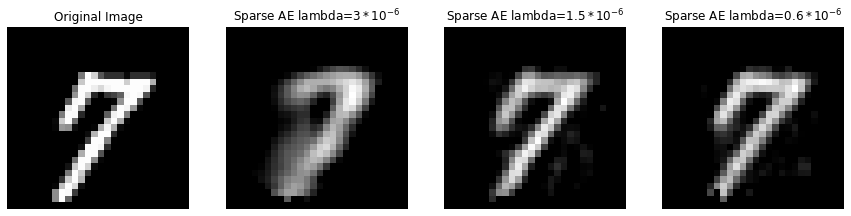

Reconstruction Error in SparseAE lambda = 3*1e-6: 29.60746996381112
Reconstruction Error in SparseAE lambda = 1.5*1e-6: 6.782359109117634
Reconstruction Error in SparseAE lambda = 0.6*1e-6: 8.19118042354352
______________________________________________________________________________________________


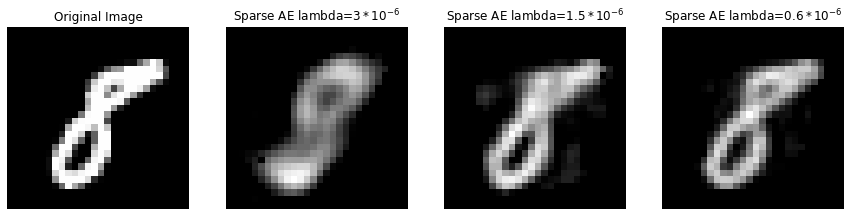

Reconstruction Error in SparseAE lambda = 3*1e-6: 34.148959339821836
Reconstruction Error in SparseAE lambda = 1.5*1e-6: 8.827630699866665
Reconstruction Error in SparseAE lambda = 0.6*1e-6: 8.819621749960914
______________________________________________________________________________________________


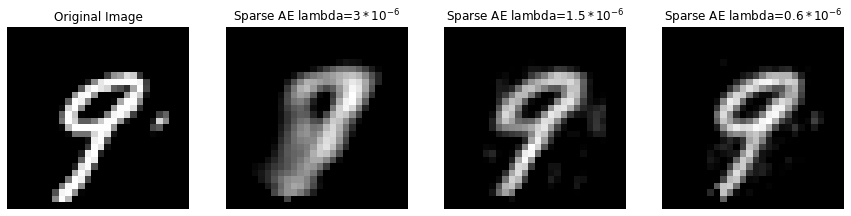

Reconstruction Error in SparseAE lambda = 3*1e-6: 29.96832909700308
Reconstruction Error in SparseAE lambda = 1.5*1e-6: 9.05938606700964
Reconstruction Error in SparseAE lambda = 0.6*1e-6: 8.93139726212009
______________________________________________________________________________________________


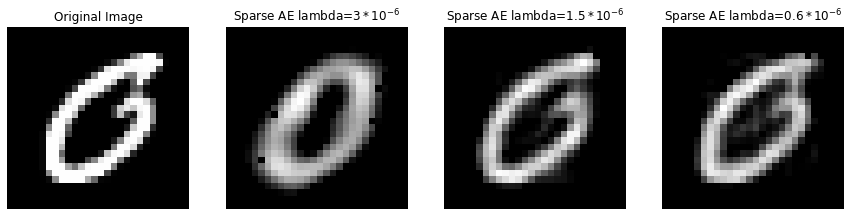

Reconstruction Error in SparseAE lambda = 3*1e-6: 30.037623122081364
Reconstruction Error in SparseAE lambda = 1.5*1e-6: 7.4294896644558595
Reconstruction Error in SparseAE lambda = 0.6*1e-6: 11.413942055486281
______________________________________________________________________________________________


In [30]:
model_3_a.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    outputs_3_a,_,activation_3_a = model_3_a(images.float())
    

model_3_b.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    outputs_3_b,_,activation_3_b = model_3_b(images.float())


model_3_c.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    outputs_3_c,_ ,activation_3_c= model_3_c(images.float())


plt.rcParams["figure.figsize"] = (15,6)

for i in range(10):
  fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_3_a[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('Sparse AE lambda=$3*10^{-6}$')
  ax2.axis("off")

  ax3.imshow(outputs_3_b[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('Sparse AE lambda=$1.5*10^{-6}$')
  ax3.axis("off")

  ax4.imshow(outputs_3_c[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('Sparse AE lambda=$0.6*10^{-6}$')
  ax4.axis("off")

  plt.show()

  print("Reconstruction Error in SparseAE lambda = 3*1e-6:",np.dot(((images[i].detach().numpy()/255)-(outputs_3_a[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_3_a[i].detach().numpy()/255)).T))
  print("Reconstruction Error in SparseAE lambda = 1.5*1e-6:",np.dot(((images[i].detach().numpy()/255)-(outputs_3_b[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_3_b[i].detach().numpy()/255)).T))
  print("Reconstruction Error in SparseAE lambda = 0.6*1e-6:",np.dot(((images[i].detach().numpy()/255)-(outputs_3_c[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_3_c[i].detach().numpy()/255)).T))  
  print("______________________________________________________________________________________________")
  

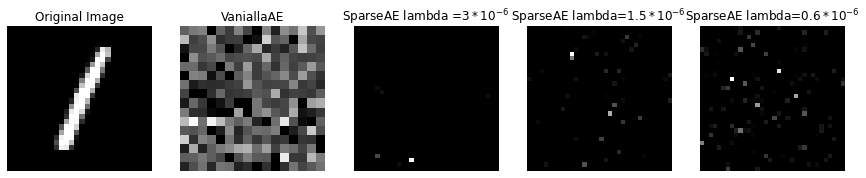

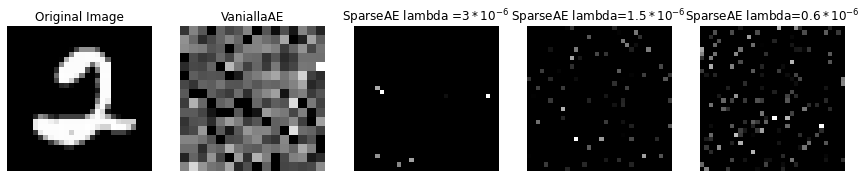

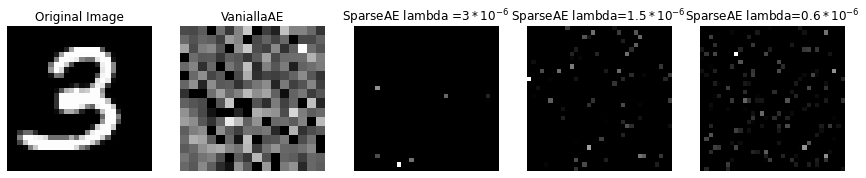

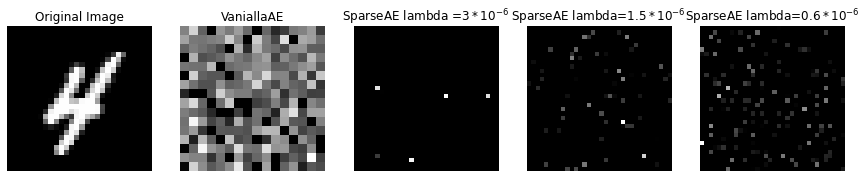

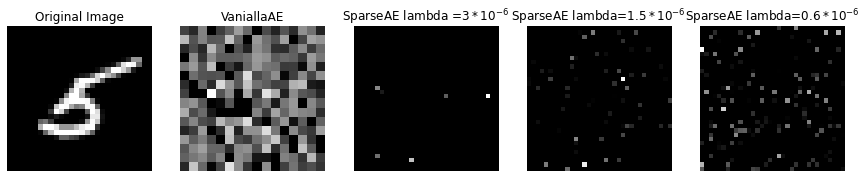

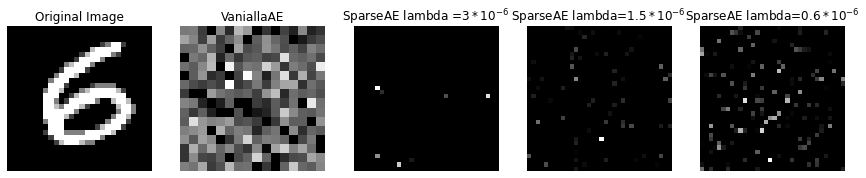

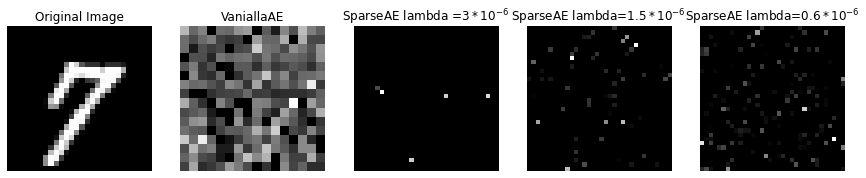

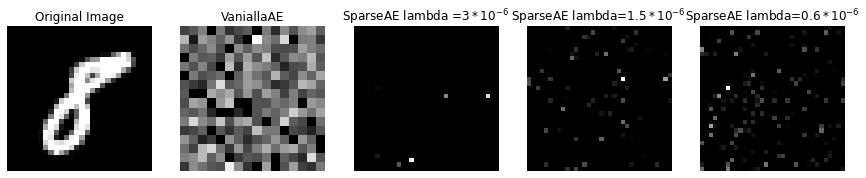

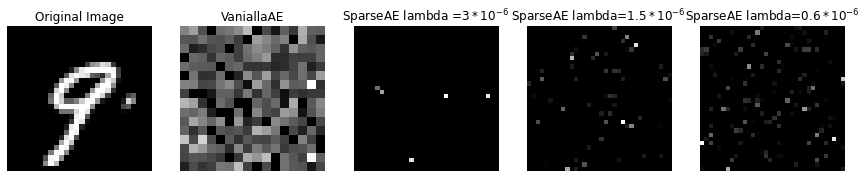

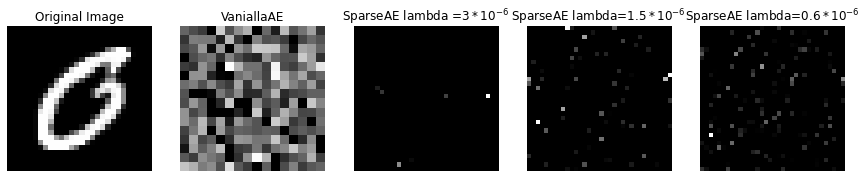

In [31]:
##VISUALISING ACTIVATIONS

plt.rcParams["figure.figsize"] = (15,6)
for i in range(10):
  fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)
  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(np.array(activations_hid256.detach().numpy())[i].reshape(int(np.sqrt(256)),int(np.sqrt(256))),cmap='gray')
  ax2.set_title('VaniallaAE')
  ax2.axis("off")

  ax3.imshow(np.array(activation_3_a.detach().numpy())[i].reshape(int(np.sqrt(1156)),int(np.sqrt(1156))),cmap='gray')
  ax3.set_title('SparseAE lambda =$3*10^{-6}$')
  ax3.axis("off")

  ax4.imshow(np.array(activation_3_b.detach().numpy())[i].reshape(int(np.sqrt(1156)),int(np.sqrt(1156))),cmap='gray')
  ax4.set_title('SparseAE lambda=$1.5*10^{-6}$')
  ax4.axis("off")

  ax5.imshow(np.array(activation_3_c.detach().numpy())[i].reshape(int(np.sqrt(1156)),int(np.sqrt(1156))),cmap='gray')
  ax5.set_title('SparseAE lambda=$0.6*10^{-6}$')
  ax5.axis("off")

plt.show()

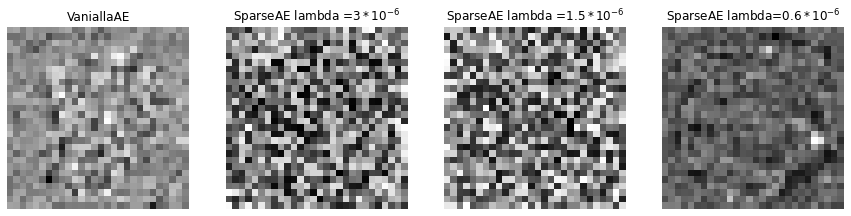

In [33]:
##VISUALISING ENCODER WEIGHTS

plt.rcParams["figure.figsize"] = (15,6)

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)
ax1.imshow(model_hid256.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax1.set_title('VaniallaAE')
ax1.axis("off")

ax2.imshow(model_3_a.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax2.set_title('SparseAE lambda =$3*10^{-6}$')
ax2.axis("off")

ax3.imshow(model_3_b.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax3.set_title('SparseAE lambda =$1.5*10^{-6}$')
ax3.axis("off")

ax4.imshow(model_3_c.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax4.set_title('SparseAE lambda=$0.6*10^{-6}$')
ax4.axis("off")

plt.show()

**Observations:**
- As lambda(sparsity factor) is decreased, reconstruction error goes down.
- If the lambda is continually decreased beyond a point then the model starts to overfit data. since the model is overcomplete, we need to iterate over the optimal lambda parameter to get desired output.

- as we decrease lambda(sparcity parameter) more neurons get activated. As can be observed from activation visualisations. However, in vanilla AE all the neurons are activated.

- Visualisation of encoder weights is difficult as nothing could be inferred from the images.

#**Question 4**

In [7]:
class AE4_DenoisingAutoencoder(nn.Module):
  def __init__(self):
    super(AE4_DenoisingAutoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784,256),
        nn.ReLU())
    self.decoder =nn.Sequential(
        nn.Linear(256,784),
        nn.ReLU())
    
  def forward(self,x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

In [8]:
def add_noise(img, noise_val):
    noise = torch.randn(img.size())*noise_val
    noisy_img = img + noise
    return noisy_img

In [18]:
#HYPERPARAMETERS
learning_rate=0.00008
epochs=10
batch_size= 300

In [10]:
model_4_a=AE4_DenoisingAutoencoder()
criterion_4_a=nn.MSELoss()
optimizer_4_a = torch.optim.Adam(model_4_a.parameters(),lr=learning_rate)

training_loss_4_a=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    noisy_images=add_noise(images,0.3)
    outputs=model_4_a(noisy_images)
    loss=criterion_4_a(outputs,images)
    training_loss_4_a.append(loss.item())

    optimizer_4_a.zero_grad()
    loss.backward()
    optimizer_4_a.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [12]:
model_4_b=AE4_DenoisingAutoencoder()
criterion_4_b=nn.MSELoss()
optimizer_4_b = torch.optim.Adam(model_4_b.parameters(),lr=learning_rate)

training_loss_4_b=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    noisy_images=add_noise(images,0.5)
    outputs=model_4_b(noisy_images)
    loss=criterion_4_b(outputs,images)
    training_loss_4_b.append(loss.item())

    optimizer_4_b.zero_grad()
    loss.backward()
    optimizer_4_b.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [13]:
model_4_c=AE4_DenoisingAutoencoder()
criterion_4_c=nn.MSELoss()
optimizer_4_c = torch.optim.Adam(model_4_c.parameters(),lr=learning_rate)

training_loss_4_c=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    noisy_images=add_noise(images,0.8)
    outputs=model_4_c(noisy_images)
    loss=criterion_4_c(outputs,images)
    training_loss_4_c.append(loss.item())

    optimizer_4_c.zero_grad()
    loss.backward()
    optimizer_4_c.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [14]:
model_4_d=AE4_DenoisingAutoencoder()
criterion_4_d=nn.MSELoss()
optimizer_4_d = torch.optim.Adam(model_4_d.parameters(),lr=learning_rate)

training_loss_4_d=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    images=images.reshape(images.shape[0],-1)
    noisy_images=add_noise(images,0.9)
    outputs=model_4_d(noisy_images)
    loss=criterion_4_d(outputs,images)
    training_loss_4_d.append(loss.item())

    optimizer_4_d.zero_grad()
    loss.backward()
    optimizer_4_d.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


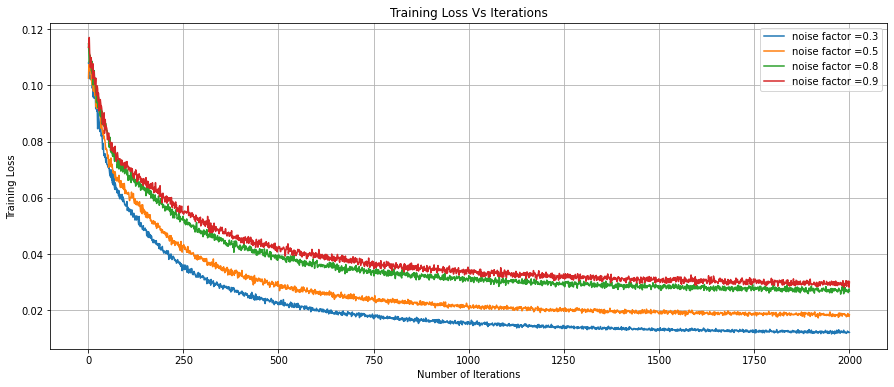

In [15]:
plt.rcParams["figure.figsize"] = (15,6)

plt.plot(range(1,len(training_loss_4_a)+1),training_loss_4_a,label="noise factor =0.3")
plt.plot(range(1,len(training_loss_4_a)+1),training_loss_4_b,label="noise factor =0.5")
plt.plot(range(1,len(training_loss_4_a)+1),training_loss_4_c,label="noise factor =0.8")
plt.plot(range(1,len(training_loss_4_a)+1),training_loss_4_d,label="noise factor =0.9")
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()

Reconstruction Error in VanillaAE with noise factor = 0.3 : 12.290545043085082
Reconstruction Error in VanillaAE with noise factor = 0.5 : 12.288547516879056
Reconstruction Error in VanillaAE with noise factor = 0.8 : 12.31252712926534
Reconstruction Error in VanillaAE with noise factor = 0.9 : 12.320034453259053


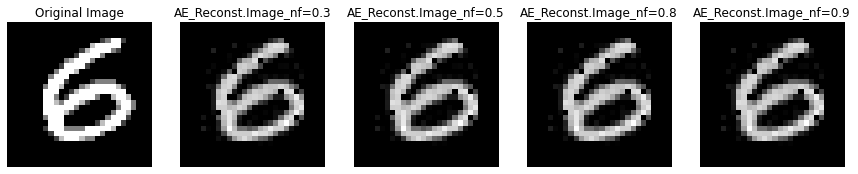

In [24]:
#INPUT WITH NOISE FACTOR=0.3,0.5,0.8,0.9 GIVEN TO VANILLA AE HIDLAYER=256
model_hid256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    # print(images.shape)
    images = images.reshape(10,28*28)
    noisy_images=add_noise(images,0.3)
    outputs_hid256_03,activations_hid256 = model_hid256(noisy_images.float())

model_hid256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images=add_noise(images,0.5)
    outputs_hid256_05,activations_hid256 = model_hid256(noisy_images.float())

model_hid256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images=add_noise(images,0.8)
    outputs_hid256_08,activations_hid256 = model_hid256(noisy_images.float())

model_hid256.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images=add_noise(images,0.9)
    outputs_hid256_09,activations_hid256 = model_hid256(noisy_images.float())

plt.rcParams["figure.figsize"] = (15,6)
i=5
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)

ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
ax1.set_title('Original Image')
ax1.axis("off")

ax2.imshow(outputs_hid256_03[i].detach().numpy().reshape(28,28),cmap='gray')
ax2.set_title('AE_Reconst.Image_nf=0.3')
ax2.axis("off")

ax3.imshow(outputs_hid256_05[i].detach().numpy().reshape(28,28),cmap='gray')
ax3.set_title('AE_Reconst.Image_nf=0.5')
ax3.axis("off")

ax4.imshow(outputs_hid256_08[i].detach().numpy().reshape(28,28),cmap='gray')
ax4.set_title('AE_Reconst.Image_nf=0.8')
ax4.axis("off")

ax5.imshow(outputs_hid256_09[i].detach().numpy().reshape(28,28),cmap='gray')
ax5.set_title('AE_Reconst.Image_nf=0.9')
ax5.axis("off")

print("Reconstruction Error in VanillaAE with noise factor = 0.3 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_03[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_03[i].detach().numpy()/255.)).T))
print("Reconstruction Error in VanillaAE with noise factor = 0.5 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_05[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_05[i].detach().numpy()/255.)).T))
print("Reconstruction Error in VanillaAE with noise factor = 0.8 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_08[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_08[i].detach().numpy()/255.)).T))
print("Reconstruction Error in VanillaAE with noise factor = 0.9 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_hid256_09[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_hid256_09[i].detach().numpy()/255.)).T))

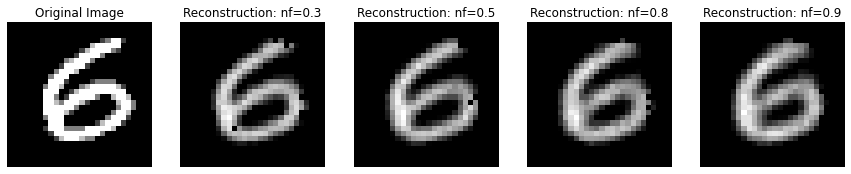

Reconstruction Error in DenoisingAE with noise factor = 0.3 : 11.504991739148307
Reconstruction Error in DenoisingAE with noise factor = 0.5 : 14.426701488962669
Reconstruction Error in DenoisingAE with noise factor = 0.8 : 19.260798583259362
Reconstruction Error in DenoisingAE with noise factor = 0.9 : 21.399583871015913
______________________________________________________________________________________________


In [16]:
model_4_a.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.3)
    outputs_4_a = model_4_a(noisy_images.float())

model_4_b.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.5)
    outputs_4_b = model_4_b(noisy_images.float())

model_4_c.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.8)
    outputs_4_c = model_4_c(noisy_images.float())

model_4_d.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.9)
    outputs_4_d = model_4_d(noisy_images.float())

plt.rcParams["figure.figsize"] = (15,6)
i=5
if i==5:
  fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_4_a[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('Reconstruction: nf=0.3')
  ax2.axis("off")

  ax3.imshow(outputs_4_b[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('Reconstruction: nf=0.5')
  ax3.axis("off")

  ax4.imshow(outputs_4_c[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('Reconstruction: nf=0.8')
  ax4.axis("off")

  ax5.imshow(outputs_4_d[i].detach().numpy().reshape(28,28),cmap='gray')
  ax5.set_title('Reconstruction: nf=0.9')
  ax5.axis("off")

  plt.show()

  print("Reconstruction Error in DenoisingAE with noise factor = 0.3 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_a[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_a[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.5 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_b[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_b[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.8 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_c[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_c[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.9 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_d[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_d[i].detach().numpy()/255.)).T))
  print("______________________________________________________________________________________________")
  

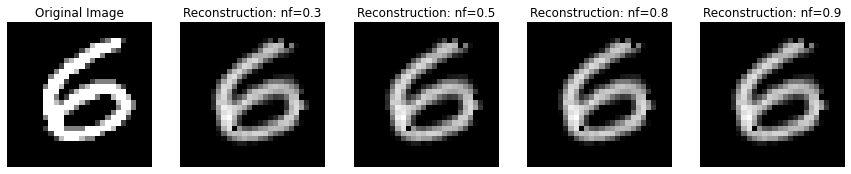

Reconstruction Error in DenoisingAE with noise factor = 0.3 : 11.504407994823417
Reconstruction Error in DenoisingAE with noise factor = 0.5 : 11.499836309490743
Reconstruction Error in DenoisingAE with noise factor = 0.8 : 11.495695934586088
Reconstruction Error in DenoisingAE with noise factor = 0.9 : 11.50995439903982
______________________________________________________________________________________________


In [25]:
#DENOISING ENCODER TRAINED ON NOISE LEVEL=0.3 AND TESTED RECONSTRUCTION FOR NOISE LEVEL 0.3,0.5,0.8,0.9
model_4_a.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images = images.reshape(10,28*28)
    noisy_images = add_noise(images,0.3)
    outputs_4_a = model_4_a(noisy_images.float())
    noisy_images = add_noise(images,0.5)
    outputs_4_b = model_4_a(noisy_images.float())
    noisy_images = add_noise(images,0.8)
    outputs_4_c = model_4_a(noisy_images.float())
    noisy_images = add_noise(images,0.9)
    outputs_4_d = model_4_a(noisy_images.float())
i=5
if i==5:
  fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_4_a[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('Reconstruction: nf=0.3')
  ax2.axis("off")

  ax3.imshow(outputs_4_b[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('Reconstruction: nf=0.5')
  ax3.axis("off")

  ax4.imshow(outputs_4_c[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('Reconstruction: nf=0.8')
  ax4.axis("off")

  ax5.imshow(outputs_4_d[i].detach().numpy().reshape(28,28),cmap='gray')
  ax5.set_title('Reconstruction: nf=0.9')
  ax5.axis("off")

  plt.show()

  print("Reconstruction Error in DenoisingAE with noise factor = 0.3 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_a[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_a[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.5 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_b[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_b[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.8 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_c[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_c[i].detach().numpy()/255.)).T))
  print("Reconstruction Error in DenoisingAE with noise factor = 0.9 :",np.dot(((images[i].detach().numpy()/255.)-(outputs_4_d[i].detach().numpy()/255.)),((images[i].detach().numpy()/255.)-(outputs_4_d[i].detach().numpy()/255.)).T))
  print("______________________________________________________________________________________________")
  

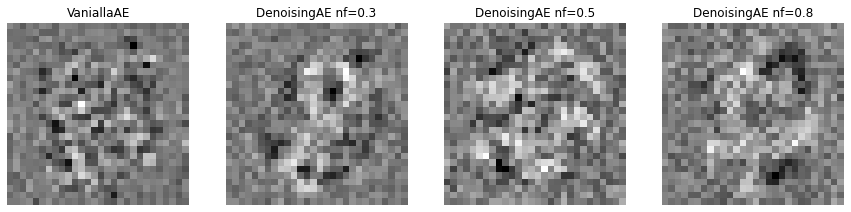

In [23]:
##VISUALISING ENCODER WEIGHTS

plt.rcParams["figure.figsize"] = (15,6)

fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)
ax1.imshow(model_hid256.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax1.set_title('VaniallaAE')
ax1.axis("off")

ax2.imshow(model_4_a.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax2.set_title('DenoisingAE nf=0.3')
ax2.axis("off")

ax3.imshow(model_4_b.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax3.set_title('DenoisingAE nf=0.5')
ax3.axis("off")

ax4.imshow(model_4_c.encoder[0].weight.detach().numpy()[0].reshape(28,28),cmap='gray')
ax4.set_title('DenoisingAE nf=0.8')
ax4.axis("off")

plt.show()

**Observations:**
- Vanilla autoencoder when given corrupted input has reconstruction error more than Denoising Autoencoder trained on noise level 0.3.
- Though not very clearly visible but encoder weights of denoising AE have some penstroke detector type visualisation.

#**Question 5**

In [26]:
class AE5_ConvAE_with_unpooling(nn.Module): #define unpooling outside the decoder and separately in forward nn.Sequential just takes one input
    
    def __init__(self): #class constructor
        super(AE5_ConvAE_with_unpooling,self).__init__() #calls the parent constructor
        
        #initializing the encoder module
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        ) # 28x28x1 to 14x14x8
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        ) #14x14x8 to 7x7x16
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        ) #7x7x16 to 3x3x16
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(nn.Identity()) #7x7x16 to 7x7x16
        self.decoder_conv2 = nn.Sequential(
            nn.Conv2d(16,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU()
        ) #14x14x16 to 14x14x8
        self.decoder_conv3 = nn.Sequential(
            nn.Conv2d(8,1, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU()
        ) #28x28x8 to 28x28x1
        
        #defining the unpooling operation
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input,indices1  = self.encoder_conv1(x.float())  # 28x28x1 to 14x14x8
        encoded_input,indices2  = self.encoder_conv2(encoded_input) #14x14x8 to 7x7x16
        encoded_input,indices3  = self.encoder_conv3(encoded_input) #7x7x16 to 3x3x16

        reconstructed_input     = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7])) #3x3x16 to 7x7x16
        reconstructed_input     = self.decoder_conv1(reconstructed_input) #7x7x16 to 7x7x16
        reconstructed_input     = self.unpool(reconstructed_input,indices2) #7x7x16 to 14x14x16
        reconstructed_input     = self.decoder_conv2(reconstructed_input)#14x14x16 to 14x14x8
        reconstructed_input     = self.unpool(reconstructed_input,indices1)#14x14x8 to 28x28x8
        reconstructed_input     = self.decoder_conv3(reconstructed_input)#28x28x8 to 28x28x1
        
        return reconstructed_input,encoded_input

In [27]:
model_5_a = AE5_ConvAE_with_unpooling()
criterion_5_a = nn.MSELoss()
optimizer_5_a = torch.optim.Adam(model_5_a.parameters(),lr=0.001)

training_loss_5_a=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    outputs,_=model_5_a(images)
    loss=criterion_5_a(outputs,images)
    training_loss_5_a.append(loss.item())

    optimizer_5_a.zero_grad()
    loss.backward()
    optimizer_5_a.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [28]:
class AE5_ConvAE_with_deconv(nn.Module):
    def __init__(self):
        super(AE5_ConvAE_with_deconv,self).__init__() 
        
        #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2))
        )
        
        #decoder module
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 2),
            nn.ReLU()
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(16,8, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(8,1, kernel_size = 4, stride = 2, padding = 1),
            nn.ReLU()
        )
        
    def forward(self,x): 
        
        encoded_input  = self.encoder_conv1(x.float())
        encoded_input  = self.encoder_conv2(encoded_input)
        encoded_input  = self.encoder_conv3(encoded_input)

        reconstructed_input = self.decoder_conv1(encoded_input)
        reconstructed_input = self.decoder_conv2(reconstructed_input)
        reconstructed_input = self.decoder_conv3(reconstructed_input)

        return reconstructed_input,encoded_input

In [29]:
model_5_b = AE5_ConvAE_with_deconv()
criterion_5_b = nn.MSELoss()
optimizer_5_b = torch.optim.Adam(model_5_b.parameters(),lr=0.001)

training_loss_5_b=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    outputs,_=model_5_b(images)
    loss=criterion_5_b(outputs,images)
    training_loss_5_b.append(loss.item())

    optimizer_5_b.zero_grad()
    loss.backward()
    optimizer_5_b.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


In [30]:
class AE5_ConvAE_with_deconv_unpool(nn.Module):
    def __init__(self): 
        super(AE5_ConvAE_with_deconv_unpool,self).__init__() 
        
         #encoder
        self.encoder_conv1 = nn.Sequential(
            nn.Conv2d(1,8, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        self.encoder_conv2 = nn.Sequential(
            nn.Conv2d(8,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        self.encoder_conv3 = nn.Sequential(
            nn.Conv2d(16,16, kernel_size = 3, stride = 1,padding= 1),
            nn.ReLU(),nn.MaxPool2d(kernel_size = (2,2),return_indices = True)
        )
        
        #initializing the decoder module
        self.decoder_conv1 = nn.Sequential(
            nn.ConvTranspose2d(16,16, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv2 = nn.Sequential(
            nn.ConvTranspose2d(16,8, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        self.decoder_conv3 = nn.Sequential(
            nn.ConvTranspose2d(8,1, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU()
        )
        
        #unpooling 
        self.unpool = nn.MaxUnpool2d(kernel_size = (2,2))
        
    def forward(self,x): #defines the forward pass and also the structure of the network thus helping backprop
        
        encoded_input,indices1  = self.encoder_conv1(x.float())
        encoded_input,indices2  = self.encoder_conv2(encoded_input)
        encoded_input,indices3  = self.encoder_conv3(encoded_input)
    
        reconstructed_input = self.unpool(encoded_input,indices3,output_size=torch.Size([batch_size, 16, 7, 7]))
        reconstructed_input = self.decoder_conv1(reconstructed_input)
        reconstructed_input = self.unpool(reconstructed_input,indices2)
        reconstructed_input = self.decoder_conv2(reconstructed_input)
        reconstructed_input = self.unpool(reconstructed_input,indices1)
        reconstructed_input = self.decoder_conv3(reconstructed_input)

        return reconstructed_input,encoded_input 

In [31]:
model_5_c = AE5_ConvAE_with_deconv_unpool()
criterion_5_c = nn.MSELoss()
optimizer_5_c = torch.optim.Adam(model_5_c.parameters(),lr=0.001)

training_loss_5_c=[]

for epoch in range(epochs):
  for images,labels in train_loader:
    outputs,_=model_5_c(images)
    loss=criterion_5_c(outputs,images)
    training_loss_5_c.append(loss.item())

    optimizer_5_c.zero_grad()
    loss.backward()
    optimizer_5_c.step()
  
  print("Epoch","[",epoch+1,"/",epochs,"]", ": completed")

Epoch [ 1 / 10 ] : completed
Epoch [ 2 / 10 ] : completed
Epoch [ 3 / 10 ] : completed
Epoch [ 4 / 10 ] : completed
Epoch [ 5 / 10 ] : completed
Epoch [ 6 / 10 ] : completed
Epoch [ 7 / 10 ] : completed
Epoch [ 8 / 10 ] : completed
Epoch [ 9 / 10 ] : completed
Epoch [ 10 / 10 ] : completed


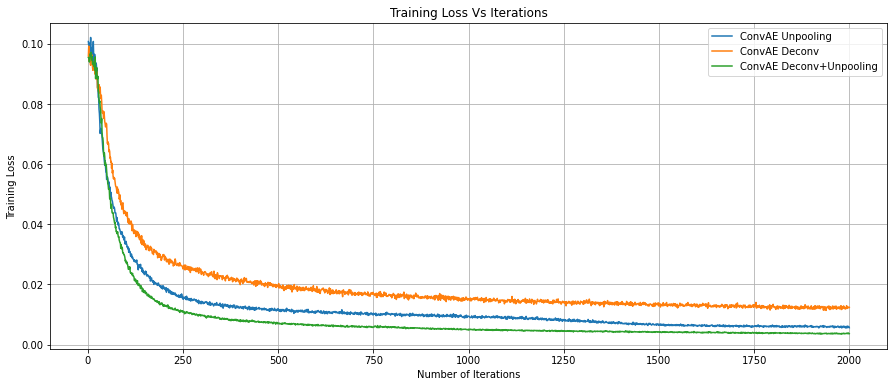

In [32]:
plt.plot(range(1,len(training_loss_5_a)+1),training_loss_5_a,label="ConvAE Unpooling")
plt.plot(range(1,len(training_loss_5_a)+1),training_loss_5_b,label="ConvAE Deconv")
plt.plot(range(1,len(training_loss_5_a)+1),training_loss_5_c,label="ConvAE Deconv+Unpooling")
plt.legend()
plt.grid()
plt.title("Training Loss Vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Training Loss")
plt.show()

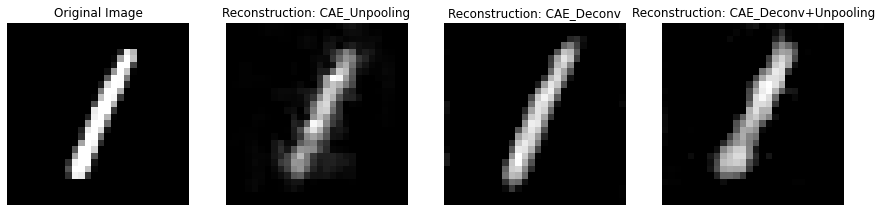

Reconstruction Error in ConvAE Unpooling: 1.7310008604428355
Reconstruction Error in ConvAE Deconv: 26.001679380843555
Reconstruction Error in ConvAE Deconv+Unpooling: 11.89297063287778
______________________________________________________________________________________________


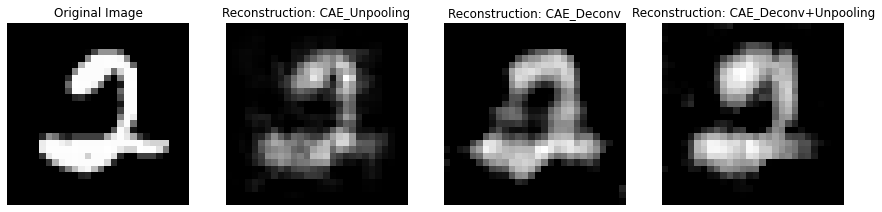

Reconstruction Error in ConvAE Unpooling: 36.132811210593644
Reconstruction Error in ConvAE Deconv: 118.04138416590519
Reconstruction Error in ConvAE Deconv+Unpooling: 93.50976356860426
______________________________________________________________________________________________


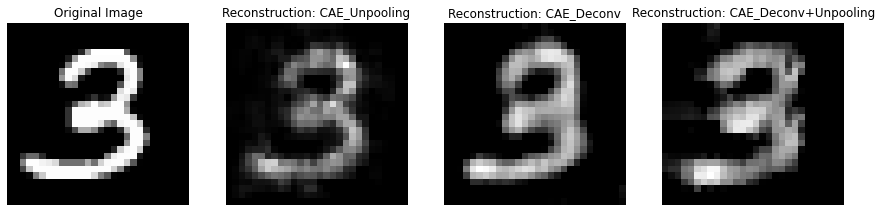

Reconstruction Error in ConvAE Unpooling: 0.2794066287723087
Reconstruction Error in ConvAE Deconv: 130.92309175297225
Reconstruction Error in ConvAE Deconv+Unpooling: 56.26377338926373
______________________________________________________________________________________________


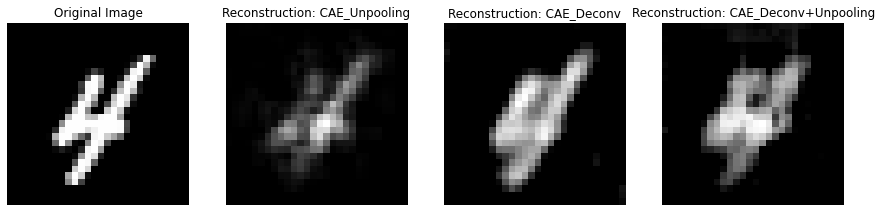

Reconstruction Error in ConvAE Unpooling: 21.321372713953124
Reconstruction Error in ConvAE Deconv: 95.42958725539685
Reconstruction Error in ConvAE Deconv+Unpooling: 38.815502513706875
______________________________________________________________________________________________


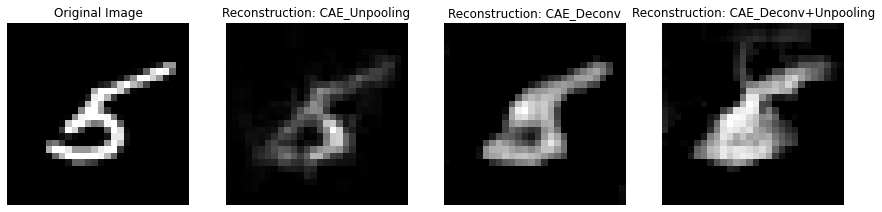

Reconstruction Error in ConvAE Unpooling: 6.22126437500681
Reconstruction Error in ConvAE Deconv: 61.48894311018323
Reconstruction Error in ConvAE Deconv+Unpooling: 9.12990892796395
______________________________________________________________________________________________


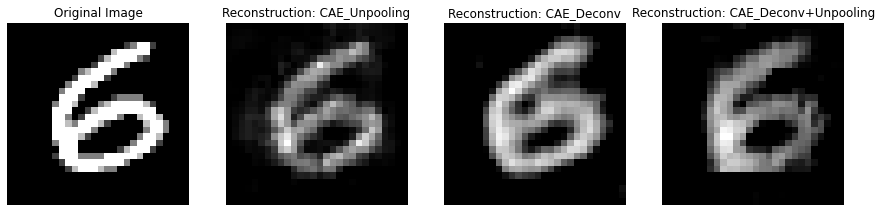

Reconstruction Error in ConvAE Unpooling: 71.43498495324837
Reconstruction Error in ConvAE Deconv: 212.74946483973974
Reconstruction Error in ConvAE Deconv+Unpooling: 168.52247765694244
______________________________________________________________________________________________


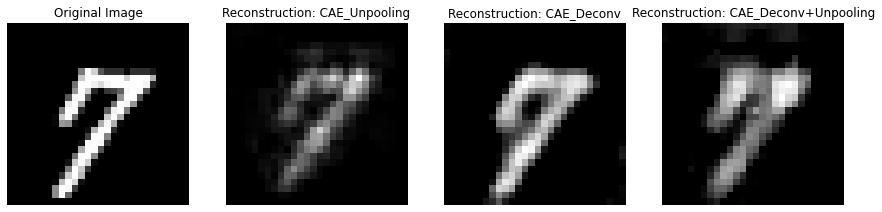

Reconstruction Error in ConvAE Unpooling: 25.535638771069415
Reconstruction Error in ConvAE Deconv: 95.00550731184873
Reconstruction Error in ConvAE Deconv+Unpooling: 35.801245134441594
______________________________________________________________________________________________


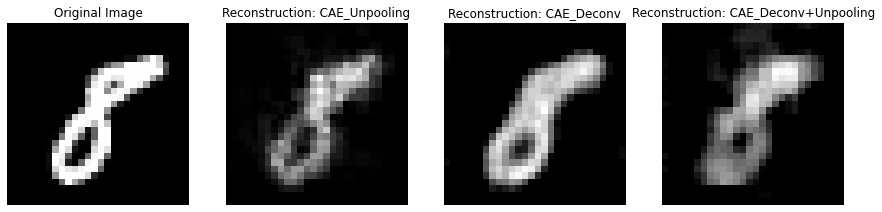

Reconstruction Error in ConvAE Unpooling: 29.760346086314858
Reconstruction Error in ConvAE Deconv: 101.14872994906563
Reconstruction Error in ConvAE Deconv+Unpooling: 53.518502795113626
______________________________________________________________________________________________


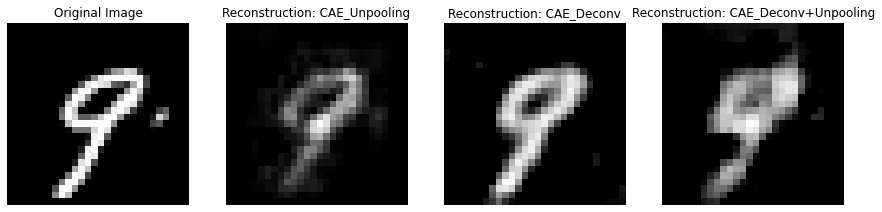

Reconstruction Error in ConvAE Unpooling: 24.24100375371164
Reconstruction Error in ConvAE Deconv: 86.583618580179
Reconstruction Error in ConvAE Deconv+Unpooling: 41.803233553557405
______________________________________________________________________________________________


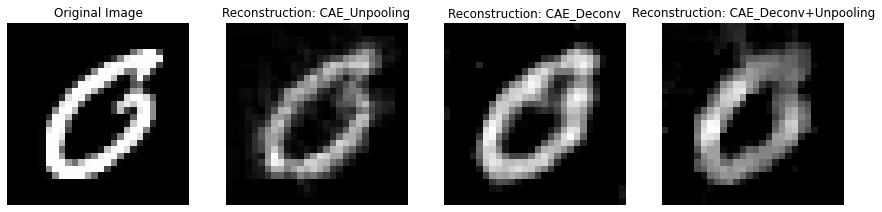

Reconstruction Error in ConvAE Unpooling: 41.52189672531831
Reconstruction Error in ConvAE Deconv: 205.93324026718437
Reconstruction Error in ConvAE Deconv+Unpooling: 80.49537718296492
______________________________________________________________________________________________


In [33]:

model_5_a.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images=images.reshape(10,1,28,28)
    outputs_5_a,_ = model_5_a(images.float())


model_5_b.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images=images.reshape(10,1,28,28)
    outputs_5_b,_ = model_5_b(images.float())
 

activation_5_c=[]
model_5_c.eval()
with torch.no_grad():
  for images in test_sample_loader:
    images=images.reshape(10,1,28,28)
    outputs_5_c,_= model_5_c(images.float())


plt.rcParams["figure.figsize"] = (15,6)

for i in range(10):
  fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4)

  ax1.imshow(images[i].detach().numpy().reshape(28,28),cmap='gray')
  ax1.set_title('Original Image')
  ax1.axis("off")

  ax2.imshow(outputs_5_a[i].detach().numpy().reshape(28,28),cmap='gray')
  ax2.set_title('Reconstruction: CAE_Unpooling')
  ax2.axis("off")

  ax3.imshow(outputs_5_b[i].detach().numpy().reshape(28,28),cmap='gray')
  ax3.set_title('Reconstruction: CAE_Deconv')
  ax3.axis("off")

  ax4.imshow(outputs_5_c[i].detach().numpy().reshape(28,28),cmap='gray')
  ax4.set_title('Reconstruction: CAE_Deconv+Unpooling')
  ax4.axis("off")

  plt.show()

  print("Reconstruction Error in ConvAE Unpooling:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs_5_a[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_5_a[i].detach().numpy()/255)).T)))
  print("Reconstruction Error in ConvAE Deconv:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs_5_b[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_5_b[i].detach().numpy()/255)).T)))
  print("Reconstruction Error in ConvAE Deconv+Unpooling:",np.sum(np.dot(((images[i].detach().numpy()/255)-(outputs_5_c[i].detach().numpy()/255)),((images[i].detach().numpy()/255)-(outputs_5_c[i].detach().numpy()/255)).T)))  
  print("______________________________________________________________________________________________")
  

In [34]:
model_5_a.encoder_conv1[0].weight.detach().numpy().squeeze().shape

(8, 3, 3)

In [35]:
#Function for visualisation of weights
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
  n,c,w,h = tensor.shape

  if allkernels: tensor = tensor.view(n*c, -1, w, h)
  elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

  rows = np.min((tensor.shape[0] // nrow + 1, 64))    
  grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
  plt.figure( figsize=(nrow,rows) )
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

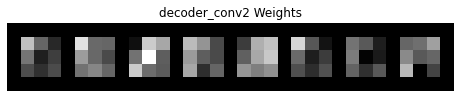

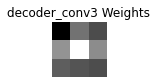

In [36]:
#VISUALISING DECODER WEIGHTS FOR CONVOLUTION AUTOENCODER WITH UNPOOLING

filter = model_5_a.decoder_conv2[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()

filter = model_5_a.decoder_conv3[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

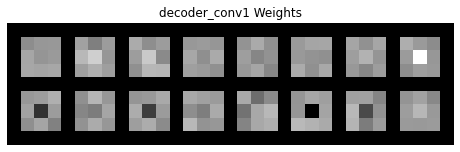

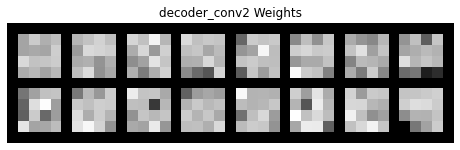

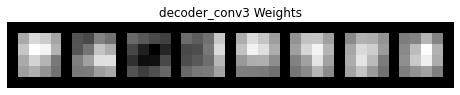

In [37]:
#VISUALISING DECODER WEIGHTS FOR CONVOLUTION AUTOENCODER WITH DECONVOLUTION

filter = model_5_b.decoder_conv1[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv1 Weights')
plt.show()

filter = model_5_b.decoder_conv2[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()

filter = model_5_b.decoder_conv3[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

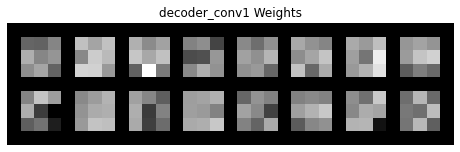

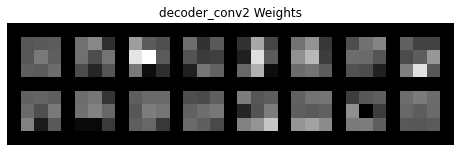

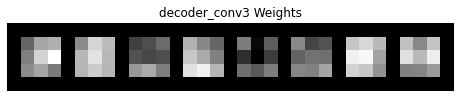

In [38]:
#VISUALISING DECODER WEIGHTS FOR CONVOLUTION AUTOENCODER WITH DECONVOLUTION+UNPOOLING

filter = model_5_c.decoder_conv1[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv1 Weights')
plt.show()

filter = model_5_c.decoder_conv2[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv2 Weights')
plt.show()

filter = model_5_c.decoder_conv3[0].weight.data.clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.title('decoder_conv3 Weights')
plt.show()

**Observations:**
- Decoder weights of Deconvolution with Unpooling and Unpooling are smaller than the only Deconvolution one.
- By looking at reconstruction error, it looks like unpooling and deconv+ unpooling does better on reconstruction of images.
- Visually, reconstructed images using Deconvolution are appealing.